# Time evolution for N>3 spins
-----------------------------------------------------------

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

In [24]:
from qiskit.circuit import Parameter

N = 6 # number of spins; scale up *slowly*, as computational load increases exponentially with N
Nhalf = int(0.5*N)
J = 1.0
Jz = 10.0

t = Parameter('t')
Nt = 20 #number of time samples
tmax = float(Nhalf)
tau_range = np.linspace(0,tmax,Nt)

ntrot = 1 #Trotter steps

qr = QuantumRegister(N,'q')
cr = ClassicalRegister(N,'c')

timecirc = QuantumCircuit(qr,cr)

In [25]:
Ngate_qr = QuantumRegister(2)
Ngate_qc = QuantumCircuit(Ngate_qr,name='N')

Ngate_qc.rz(-0.5*np.pi,Ngate_qr[1])
Ngate_qc.cx(Ngate_qr[1],Ngate_qr[0])
Ngate_qc.rz(0.5*np.pi-2*Jz*t/(4.0*ntrot),Ngate_qr[0])
Ngate_qc.ry(2.0*J*t/(4.0*ntrot)-0.5*np.pi,Ngate_qr[1])
Ngate_qc.cx(Ngate_qr[0],Ngate_qr[1])
Ngate_qc.ry(0.5*np.pi-2.0*J*t/(4.0*ntrot),Ngate_qr[1])
Ngate_qc.cx(Ngate_qr[1],Ngate_qr[0])
Ngate_qc.rz(0.5*np.pi,Ngate_qr[0])

N_gate = Ngate_qc.to_instruction()

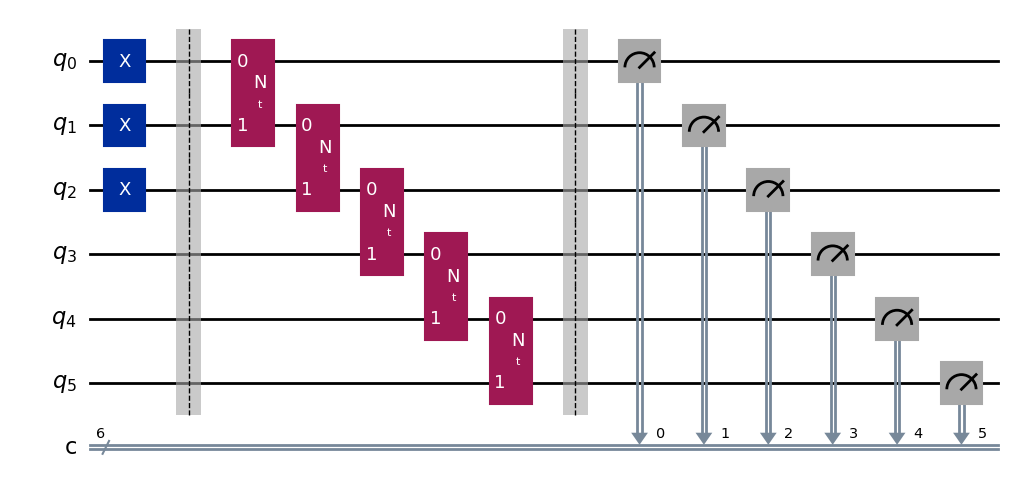

In [26]:
#domain wall initial state |ψ> = |++...++--...-->
timecirc.x(qr[0:Nhalf])

timecirc.barrier()

for _ in range(0,ntrot):
    for i in range(0,N-1):
        timecirc.append(N_gate, [qr[i], qr[i+1]])

timecirc.barrier()
timecirc.measure(qr,cr)
timecirc.draw("mpl")

In [6]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

In [ ]:
Szt = np.zeros((N,Nt))

for i in range(0,Nt):
    simcounts = result.data.c.get_counts(i)
    keylist = list(simcounts.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]
        
        for k in range(0,N):
            if (state[k]=='0'):
                Szt[k,i] = Szt[k,i] + simcounts[state]
            else:
                Szt[k,i] = Szt[k,i] - simcounts[state]
        
Szt = 0.5*Szt/nshots

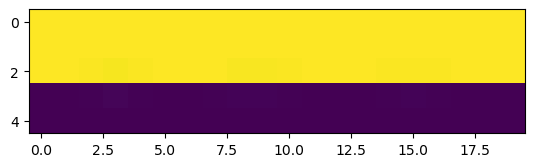

In [8]:
plt.imshow(Szt)
plt.show()

## Equivalent execution using ```Estimator``` (more computationally efficient)

In [9]:
N = 5 # number of spins; scale up *slowly*, as computational load increases exponentially with N
Nhalf = int(0.5*N)
J = 1.0
Jz = 0.10

t = Parameter('t')
Nt = 20 #number of time samples
tmax = float(Nhalf)
tau_range = np.linspace(0,tmax,Nt)

ntrot = 100 #Trotter steps

qr = QuantumRegister(N,'q')
cr = ClassicalRegister(N,'c')

timecirc = QuantumCircuit(qr,cr)

#domain wall initial state |ψ> = |++...++--...-->
timecirc.x(qr[0:Nhalf])

for _ in range(0,ntrot):
    for i in range(0,N-1):
        timecirc.append(N_gate, [qr[i], qr[i+1]])

In [10]:
from qiskit.quantum_info import SparsePauliOp

pad = "I"
for j in range(0,N-2):
    pad = pad + "I"
    
Sop = [[SparsePauliOp.from_list([("Z"+pad, 0.5)])]]

for i in range(0,N):
    if (i==N-1):
        pad = "I"
        for j in range(0,N-2):
            pad = pad + "I"
            
        Sop.append([SparsePauliOp.from_list([(pad+"Z", 0.5)])])
    
    else:
        if (i!=0):
            l = "I"
            for j in range(0,i-1):
                l = l + "I"
    
            r = "I"
            for j in range(0,N-i-2):
                r = r + "I"
            
            Sop.append([SparsePauliOp.from_list([(l + "Z" + r, 0.5)])])
                


In [11]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

pub = (
    timecirc,  # circuit
    Sop,  # Observables
    tau_range,
)

job_result = estimator.run(pubs=[pub]).result()

In [15]:
Szt = np.zeros((N,Nt))

for i in range(0,N):
    print(job_result)
    print(job_result[0].data)
    print(job_result[0].data.evs)
    Szt[i,:] = job_result[0].data.evs[i]

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(5, 20), dtype=float64>), stds=np.ndarray(<shape=(5, 20), dtype=float64>), shape=(5, 20)), metadata={'target_precision': 0.0, 'circuit_metadata': {}})], metadata={'version': 2})
DataBin(evs=np.ndarray(<shape=(5, 20), dtype=float64>), stds=np.ndarray(<shape=(5, 20), dtype=float64>), shape=(5, 20))
[[ 0.5         0.5         0.49999997  0.49999968  0.49999866  0.49999651
   0.49999352  0.49999084  0.49998967  0.49999027  0.4999917   0.49999276
   0.49999309  0.49999322  0.49999341  0.49999268  0.49998943  0.49998318
   0.49997588  0.49997083]
 [ 0.5         0.49999816  0.49997582  0.49991221  0.4998286   0.4997782
   0.49977927  0.499774    0.49967917  0.49948531  0.49928768  0.49919525
   0.49920541  0.49918914  0.49902187  0.49872897  0.49847992  0.49841875
   0.49850326  0.49853326]
 [ 0.5         0.49748166  0.49251457  0.49017412  0.49277583  0.49754551
   0.49958248  0.49694733  0.49256559  0.49107079  0.49400262  0.4983

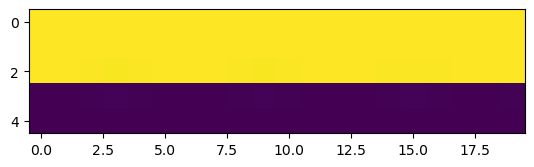

In [13]:
plt.imshow(Szt)
plt.show()

## Version information:

In [18]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'